In [10]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import matplotlib.pyplot as plt
import numpy as np

In [14]:
import numpy as np 
import matplotlib.pyplot as plt
 
def carry_k(state, theta, chi):
	'''
	carry U operatior on state
	suppose U=exp(-i*theta/2*sigmaz)
	'''
	U = np.array([[np.cos(theta/2)-1j*np.sin(theta/2)*np.sin(chi), -np.sin(theta/2)*np.cos(chi)],[np.sin(theta/2)*np.cos(chi), np.cos(theta/2)+1j*np.sin(theta/2)*np.sin(chi)]])
	final_state = np.dot(U, state)

	return final_state


def carry_z(state, theta):
	'''
	carry U operatior on state
	suppose U=exp(-i*theta/2*sigmaz)
	'''
	U = np.array([[np.cos(theta/2)-1j * np.sin(theta/2), 0],[0, np.cos(theta/2)+ 1j * np.sin(theta/2)]])
	final_state = np.dot(U, state)

	return final_state

def carry_y(state, theta):
	'''
	carry U operatior on state
	suppose U=exp(-i*theta/2*sigmay)
	'''
	U = np.array([[np.cos(theta/2), -np.sin(theta/2)],[np.sin(theta/2), np.cos(theta/2)]])
	final_state = np.dot(U, state)

	return final_state

def blue_carry(state, theta):
	'''
	blue carry U on state
	suppose U=exp(-i*theta/2*sigmay)
	and |0>-->|1>,phonon number plus 1
	|1>-->|0>, phonon number minus 1
	'''
	# U operator on up and down level of state
	state_up = np.vstack((state[0], np.zeros(len(state[0]))))
	state_down = np.vstack((np.zeros(len(state[0])), state[1]))
	U = np.array([[np.cos(theta/2), -np.sin(theta/2)], [np.sin(theta/2), np.cos(theta/2)]])
	carry_state_up = np.dot(U, state_up)
	carry_state_down = np.dot(U, state_down)
	# after U operation, down level minus 1
	up_state = carry_state_up[0]
	down_state_minus = carry_state_up[1]
	down_state_minus_0 = state_up[0][0]  # blue carry can not drive the phonon=0 && up level
	down_state_minus = np.delete(down_state_minus, 0)
	down_state_minus = np.insert(down_state_minus, len(down_state_minus)-1, 0)
	# after U operation, up level plus 1
	up_state_plus = carry_state_down[0]
	down_state = carry_state_down[1]
	up_state_plus = np.insert(up_state_plus, 0, down_state_minus_0)
	up_state_plus = np.delete(up_state_plus, len(up_state_plus)-1)
	# probability add up and down level
	up = up_state + up_state_plus
	down = down_state_minus + down_state
	final_state = np.vstack((up, down))

	return final_state

def red_carry(state, theta):
	'''
	red carry U on state
	suppose U=exp(-i*theta/2*sigmay)
	and |0>-->|1>,phonon number minus 1
	|1>-->|0>, phonon number plus 1
	'''
	# U operator on up and down level of state
	state_up = np.vstack((state[0], np.zeros(len(state[0]))))
	state_down = np.vstack((np.zeros(len(state[0])), state[1]))
	U = np.array([[np.cos(theta/2), -np.sin(theta/2)],[np.sin(theta/2), np.cos(theta/2)]])
	carry_state_up = np.dot(U, state_up)
	carry_state_down = np.dot(U, state_down)
	# after U operation, up level minus 1
	up_state_minus = carry_state_down[0]
	down_state = carry_state_down[1]
	up_state_minus_0 = state_down[1][0] # red carry can not drive the phonon=0 && down level
	up_state_minus = np.delete(up_state_minus,0)
	up_state_minus = np.insert(up_state_minus,len(up_state_minus)-1,0)
	# after U operation, down level plus 1
	up_state = carry_state_up[0]
	down_state_plus = carry_state_up[1]
	down_state_plus = np.insert(down_state_plus,0,up_state_minus_0)
	down_state_plus = np.delete(down_state_plus,len(down_state_plus)-1)
	# probability add up and down level
	up = up_state + up_state_minus
	down = down_state_plus + down_state
	final_state = np.vstack((up, down))

	return final_state

def Operator(up_state, down_state, func, theta):
	'''
	operator include carry, blue and red
	'''
	state = np.vstack((up_state, down_state))
	state = func(state, theta)

	return state[0], state[1]

def Operator_k(up_state, down_state, theta, chi):
	'''
	operator include carry, blue and red
	'''
	state = np.vstack((up_state, down_state))
	state = carry_k(state, theta, chi)

	return state[0], state[1]

def one_step_2_y(state, theta_1, theta_2):
	'''
	one step of complete quantum walk
	may with the help of auxiliary level
	input state of three level
	output state of three level
	T1:up-->right
	t2:down-->left 
	T1R1T2R2
	'''
	up_state = state[0]
	down_state = state[1]
	aux_state = state[2]
	up_state, down_state = Operator(up_state, down_state, carry_y, theta_2)
	aux_state, down_state = Operator(aux_state, down_state, red_carry, np.pi)
	up_state, down_state = Operator(up_state, down_state, carry_y, np.pi)
	aux_state, down_state = Operator(aux_state, down_state, carry_y, theta_1)
	up_state, down_state = Operator(up_state, down_state, blue_carry, np.pi)
	aux_state, down_state = Operator(aux_state, down_state, carry_y, np.pi)

	state = np.vstack((up_state, down_state, aux_state))
	return state

def N_step_2_y(state, theta_1, theta_2, N):
	'''
	N step of complete quantum walk
	'''
	for i in range(N):
		state = one_step_2_y(state, theta_1, theta_2)
	return state

def one_step_2_z(state, theta_1, theta_2):
	'''
	one step of complete quantum walk
	may with the help of auxiliary level
	input state of three level
	output state of three level
	T1:up-->right
	t2:down-->left 
	T1R1T2R2
	'''
	up_state = state[0]
	down_state = state[1]
	aux_state = state[2]
	up_state, down_state = Operator(up_state, down_state, carry_z, theta_2)
	aux_state, down_state = Operator(aux_state, down_state, red_carry, np.pi)
	up_state, down_state = Operator(up_state, down_state, carry_y, np.pi)
	aux_state, down_state = Operator(aux_state, down_state, carry_z, theta_1)
	up_state, down_state = Operator(up_state, down_state, blue_carry, np.pi)
	aux_state, down_state = Operator(aux_state, down_state, carry_y, np.pi)

	state = np.vstack((up_state, down_state, aux_state))
	return state

def N_step_2_z(state, theta_1, theta_2, N):
	'''
	N step of complete quantum walk
	'''
	for i in range(N):
		state = one_step_2_z(state, theta_1, theta_2)
	return state

def one_step_2_k(state, theta_1, theta_2, chi):
	'''
	one step of complete quantum walk
	may with the help of auxiliary level
	input state of three level
	output state of three level
	T1:up-->right
	t2:down-->left 
	T1R1T2R2
	'''
	up_state = state[0]
	down_state = state[1]
	aux_state = state[2]
	up_state, down_state = Operator(up_state, down_state, carry_y, theta_2)
	aux_state, down_state = Operator(aux_state, down_state, red_carry, np.pi)
	up_state, down_state = Operator(up_state, down_state, carry_y, np.pi)
	aux_state, down_state = Operator_k(aux_state, down_state, theta_1, chi)
	up_state, down_state = Operator(up_state, down_state, blue_carry, np.pi)
	aux_state, down_state = Operator(aux_state, down_state, carry_y, np.pi)

	state = np.vstack((up_state, down_state, aux_state))
	return state

def N_step_2_k(state, theta_1, theta_2, chi, N):
	'''
	N step of complete quantum walk
	'''
	for i in range(N):
		state = one_step_2_k(state, theta_1, theta_2, chi)
	return state


def one_step_2_K(state, theta_1, theta_2, chi):
	'''
	one step of complete quantum walk
	may with the help of auxiliary level
	input state of three level
	output state of three level
	T1:up-->right
	t2:down-->left 
	T1R1T2R2
	'''
	up_state = state[0]
	down_state = state[1]
	aux_state = state[2]
	up_state, down_state = Operator_k(up_state, down_state, theta_2, chi)
	aux_state, down_state = Operator(aux_state, down_state, red_carry, np.pi)
	up_state, down_state = Operator(up_state, down_state, carry_y, np.pi)
	aux_state, down_state = Operator_k(aux_state, down_state, theta_1, chi)
	up_state, down_state = Operator(up_state, down_state, blue_carry, np.pi)
	aux_state, down_state = Operator(aux_state, down_state, carry_y, np.pi)

	state = np.vstack((up_state, down_state, aux_state))
	return state

def N_step_2_K(state, theta_1, theta_2, chi, N):
	'''
	N step of complete quantum walk
	'''
	for i in range(N):
		state = one_step_2_K(state, theta_1, theta_2, chi)
	return state

def one_step_2_ch_1(state, theta_1, theta_2):
	'''
	one step of complete quantum walk
	may with the help of auxiliary level
	input state of three level
	output state of three level
	T1:up-->right
	T2:down-->left 
	T1R1T2R2T1T2
	'''
	up_state = state[0]
	down_state = state[1]
	aux_state = state[2]
	aux_state, down_state = Operator(aux_state, down_state, red_carry, np.pi)
	up_state, down_state = Operator(up_state, down_state, carry_y, np.pi)
	up_state, down_state = Operator(up_state, down_state, blue_carry, np.pi)
	aux_state, down_state = Operator(aux_state, down_state, carry_y, np.pi)
	up_state, down_state = Operator(up_state, down_state, carry_y, theta_2)
	aux_state, down_state = Operator(aux_state, down_state, red_carry, np.pi)
	up_state, down_state = Operator(up_state, down_state, carry_y, np.pi)
	aux_state, down_state = Operator(aux_state, down_state, carry_y, theta_1)
	up_state, down_state = Operator(up_state, down_state, blue_carry, np.pi)
	aux_state, down_state = Operator(aux_state, down_state, carry_y, np.pi)

	state = np.vstack((up_state, down_state, aux_state))
	return state

def N_step_2_ch_1(state, theta_1, theta_2, N):
	'''
	N step of complete quantum walk
	'''
	for i in range(N):
		state = one_step_2_ch_1(state, theta_1, theta_2)
	return state

def one_step_2_ch_2(state, theta_1, theta_2):
	'''
	one step of complete quantum walk
	may with the help of auxiliary level
	input state of three level
	output state of three level
	T1:up-->right
	T2:down-->left 
	T1R1T2R2T1T2
	'''
	up_state = state[0]
	down_state = state[1]
	aux_state = state[2]
	up_state, down_state = Operator(up_state, down_state, carry_y, theta_2)
	aux_state, down_state = Operator(aux_state, down_state, red_carry, np.pi)
	up_state, down_state = Operator(up_state, down_state, carry_y, np.pi)
	aux_state, down_state = Operator(aux_state, down_state, carry_y, theta_1)
	up_state, down_state = Operator(up_state, down_state, blue_carry, np.pi)
	aux_state, down_state = Operator(aux_state, down_state, carry_y, np.pi)
	aux_state, down_state = Operator(aux_state, down_state, red_carry, np.pi)
	up_state, down_state = Operator(up_state, down_state, carry_y, np.pi)
	up_state, down_state = Operator(up_state, down_state, blue_carry, np.pi)
	aux_state, down_state = Operator(aux_state, down_state, carry_y, np.pi)

	state = np.vstack((up_state, down_state, aux_state))
	return state

def N_step_2_ch_2(state, theta_1, theta_2, N):
	'''
	N step of complete quantum walk
	'''
	for i in range(N):
		state = one_step_2_ch_2(state, theta_1, theta_2)
	return state

In [15]:
M = 150
n = 1
N = 100
p1_y = np.zeros(101)
p2_y = np.zeros(101)
up_state = [0]*M
down_state = [0]*M
aux_state = [0]*M
# up_state[1] = 1/np.sqrt(2)
# down_state[0] = -1j/np.sqrt(2)
down_state[0] = 1
theta_2 = np.linspace(-2*np.pi,2*np.pi,101)
theta_1 = np.pi/2
np.array(up_state)
np.array(down_state)
np.array(aux_state)
init_state = np.vstack((up_state, down_state, aux_state))
for i,theta in enumerate(theta_2):
    state1 = N_step_2_y(init_state, theta_1, theta, N=100)
    state2 = N_step_2_y(init_state, -theta_1, theta, N=100)
    P1 = abs(state1[0])**2 + abs(state1[1])**2 + abs(state1[2])**2
    P2 = abs(state2[0])**2 + abs(state2[1])**2 + abs(state2[2])**2
    p1_y[i] = P1[0] + P1[1] 
    p2_y[i] = P2[0] + P2[1] 

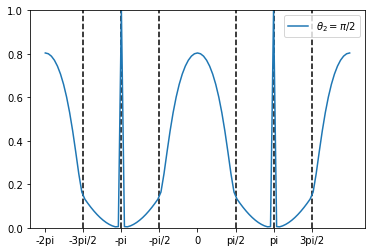

In [16]:
plt.plot(theta_2, p1_y, label='$ \\theta_2 = \pi/2$')
plt.ylim(top = 1,bottom = 0)
my_x_ticks = np.arange(-2*np.pi,2*np.pi,np.pi/2) 
plt.xticks(my_x_ticks,('-2pi','-3pi/2','-pi','-pi/2','0','pi/2','pi','3pi/2','2pi'))
plt.vlines(-3*np.pi/2, 0, 1, linestyles = "dashed")
plt.vlines(-np.pi, 0, 1, linestyles = "dashed")
plt.vlines(-np.pi/2, 0, 1, linestyles = "dashed")
plt.vlines(np.pi/2, 0, 1, linestyles = "dashed")
plt.vlines(np.pi, 0, 1, linestyles = "dashed")
plt.vlines(3*np.pi/2, 0, 1, linestyles = "dashed")
plt.legend(loc='best') 

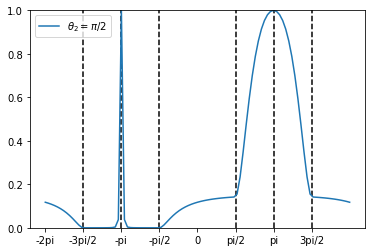

In [63]:
plt.plot(theta_2, p2_y, label='$ \\theta_2 = \pi/2$')
plt.ylim(top = 1,bottom = 0)
my_x_ticks = np.arange(-2*np.pi,2*np.pi,np.pi/2) 
plt.xticks(my_x_ticks,('-2pi','-3pi/2','-pi','-pi/2','0','pi/2','pi','3pi/2','2pi'))
plt.vlines(-3*np.pi/2, 0, 1, linestyles = "dashed")
plt.vlines(-np.pi, 0, 1, linestyles = "dashed")
plt.vlines(-np.pi/2, 0, 1, linestyles = "dashed")
plt.vlines(np.pi/2, 0, 1, linestyles = "dashed")
plt.vlines(np.pi, 0, 1, linestyles = "dashed")
plt.vlines(3*np.pi/2, 0, 1, linestyles = "dashed")
plt.legend(loc='best') 

In [328]:
M = 150
n = 1
N = 100
p1_z = np.zeros(101)
p2_z = np.zeros(101)
up_state = [0]*M
down_state = [0]*M
aux_state = [0]*M
# up_state[1] = 1/np.sqrt(2)
# down_state[0] = -1j/np.sqrt(2)
down_state[0] = 1
theta_2 = np.linspace(-2*np.pi,2*np.pi,101)
theta_1 = np.pi/4
np.array(up_state)
np.array(down_state)
np.array(aux_state)
init_state = np.vstack((up_state, down_state, aux_state))
for i,theta in enumerate(theta_2):
    state1 = N_step_2_z(init_state, theta_1, theta, N=50)
    state2 = N_step_2_z(init_state, -theta_1, theta, N=50)
    P1 = abs(state1[0])**2 + abs(state1[1])**2 + abs(state1[2])**2
    P2 = abs(state2[0])**2 + abs(state2[1])**2 + abs(state2[2])**2
    p1_z[i] = P1[0] + P1[1]
    p2_z[i] = P2[0] + P2[1]

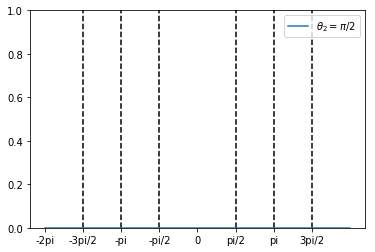

In [329]:
plt.plot(theta_2, p1_z, label='$ \\theta_2 = \pi/2$')
plt.ylim(top = 1,bottom = 0)
my_x_ticks = np.arange(-2*np.pi,2*np.pi,np.pi/2) 
plt.xticks(my_x_ticks,('-2pi','-3pi/2','-pi','-pi/2','0','pi/2','pi','3pi/2','2pi'))
plt.vlines(-3*np.pi/2, 0, 1, linestyles = "dashed")
plt.vlines(-np.pi, 0, 1, linestyles = "dashed")
plt.vlines(-np.pi/2, 0, 1, linestyles = "dashed")
plt.vlines(np.pi/2, 0, 1, linestyles = "dashed")
plt.vlines(np.pi, 0, 1, linestyles = "dashed")
plt.vlines(3*np.pi/2, 0, 1, linestyles = "dashed")
plt.legend(loc='best') 

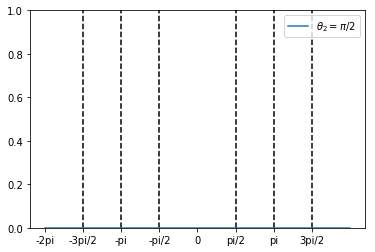

In [330]:
plt.plot(theta_2, p2_z, label='$ \\theta_2 = \pi/2$')
plt.ylim(top = 1,bottom = 0)
my_x_ticks = np.arange(-2*np.pi,2*np.pi,np.pi/2) 
plt.xticks(my_x_ticks,('-2pi','-3pi/2','-pi','-pi/2','0','pi/2','pi','3pi/2','2pi'))
plt.vlines(-3*np.pi/2, 0, 1, linestyles = "dashed")
plt.vlines(-np.pi, 0, 1, linestyles = "dashed")
plt.vlines(-np.pi/2, 0, 1, linestyles = "dashed")
plt.vlines(np.pi/2, 0, 1, linestyles = "dashed")
plt.vlines(np.pi, 0, 1, linestyles = "dashed")
plt.vlines(3*np.pi/2, 0, 1, linestyles = "dashed")
plt.legend(loc='best') 

In [344]:
M = 150
n = 1
N = 100
p1_k = np.zeros(101)
p2_k = np.zeros(101)
up_state = [0]*M
down_state = [0]*M
aux_state = [0]*M
# up_state[1] = 1/np.sqrt(2)
# down_state[0] = -1j/np.sqrt(2)
down_state[0] = 1
theta_2 = np.linspace(-2*np.pi,2*np.pi,101)
theta_1 = np.pi/2
chi = np.pi/3
np.array(up_state)
np.array(down_state)
np.array(aux_state)
init_state = np.vstack((up_state, down_state, aux_state))
for i,theta in enumerate(theta_2):
    state1 = N_step_2_k(init_state, theta, theta_1, chi, N=50)
    state2 = N_step_2_k(init_state, theta, -theta_1, chi, N=50)
    P1 = abs(state1[0])**2 + abs(state1[1])**2 + abs(state1[2])**2
    P2 = abs(state2[0])**2 + abs(state2[1])**2 + abs(state2[2])**2
    p1_k[i] = P1[0] + P1[1] 
    p2_k[i] = P2[0] + P2[1] 

Text(0.5, 0, '$\\chi$')

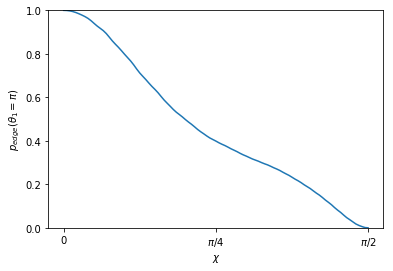

In [368]:
Chi = np.linspace(0,np.pi/2,101)
p_k = np.zeros(101)
for i,chi in enumerate(Chi):
    state = N_step_2_K(init_state, np.pi, theta_1, chi, N=70)
    P = abs(state[0])**2 + abs(state[1])**2 + abs(state[2])**2
    p_k[i] = P[0] 
plt.plot(Chi, p_k)
plt.ylim(top = 1,bottom = 0)
my_x_ticks = [0,np.pi/4,np.pi/2] 
plt.xticks(my_x_ticks,('0','$\\pi/4$','$\\pi/2$'))
##plt.vlines(np.pi/4, 0, 0.2, linestyles = "dashed")
plt.ylabel('$p_{edge} (\\theta_1= \\pi)$')
plt.xlabel('$\chi$')

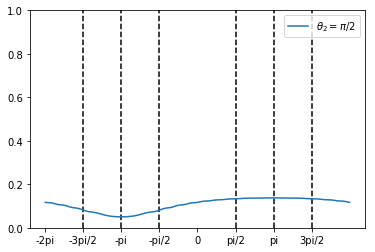

In [345]:
plt.plot(theta_2, p1_k, label='$ \\theta_2 = \pi/2$')
plt.ylim(top = 1,bottom = 0)
my_x_ticks = np.arange(-2*np.pi,2*np.pi,np.pi/2) 
plt.xticks(my_x_ticks,('-2pi','-3pi/2','-pi','-pi/2','0','pi/2','pi','3pi/2','2pi'))
plt.vlines(-3*np.pi/2, 0, 1, linestyles = "dashed")
plt.vlines(-np.pi, 0, 1, linestyles = "dashed")
plt.vlines(-np.pi/2, 0, 1, linestyles = "dashed")
plt.vlines(np.pi/2, 0, 1, linestyles = "dashed")
plt.vlines(np.pi, 0, 1, linestyles = "dashed")
plt.vlines(3*np.pi/2, 0, 1, linestyles = "dashed")
plt.legend(loc='best') 

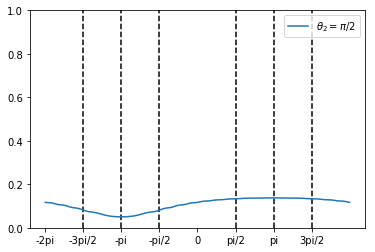

In [346]:
plt.plot(theta_2, p2_k, label='$ \\theta_2 = \pi/2$')
plt.ylim(top = 1,bottom = 0)
my_x_ticks = np.arange(-2*np.pi,2*np.pi,np.pi/2) 
plt.xticks(my_x_ticks,('-2pi','-3pi/2','-pi','-pi/2','0','pi/2','pi','3pi/2','2pi'))
plt.vlines(-3*np.pi/2, 0, 1, linestyles = "dashed")
plt.vlines(-np.pi, 0, 1, linestyles = "dashed")
plt.vlines(-np.pi/2, 0, 1, linestyles = "dashed")
plt.vlines(np.pi/2, 0, 1, linestyles = "dashed")
plt.vlines(np.pi, 0, 1, linestyles = "dashed")
plt.vlines(3*np.pi/2, 0, 1, linestyles = "dashed")

plt.legend(loc='best') 

In [4]:
M = 150
n = 1
N = 100
p1_K = np.zeros(101)
p2_K = np.zeros(101)
up_state = [0]*M
down_state = [0]*M
aux_state = [0]*M
# up_state[1] = 1/np.sqrt(2)
# down_state[0] = -1j/np.sqrt(2)
down_state[0] = 1
theta_2 = np.linspace(-2*np.pi,2*np.pi,101)
theta_1 = np.pi/2
chi = np.pi/3
np.array(up_state)
np.array(down_state)
np.array(aux_state)
init_state = np.vstack((up_state, down_state, aux_state))
for i,theta in enumerate(theta_2):
#     state1 = N_step_2_ch_1(init_state, theta, theta_1, N=70)
#     state2 = N_step_2_ch_1(init_state, theta, -theta_1, N=70)
    state1 = N_step_2_K(init_state, theta_1, theta, chi, N=70)
    state2 = N_step_2_K(init_state, -theta_1, theta, chi, N=70)
    P1 = abs(state1[0])**2 + abs(state1[1])**2 + abs(state1[2])**2
    P2 = abs(state2[0])**2 + abs(state2[1])**2 + abs(state2[2])**2
    p1_K[i] = P1[0] + P1[1] 
    p2_K[i] = P2[0] + P2[1] 

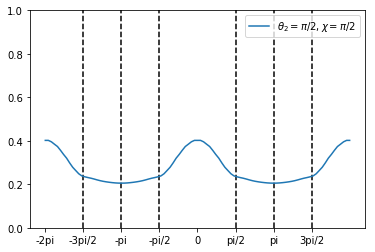

In [7]:
plt.plot(theta_2, p1_K, label='$ \\theta_2 = \pi/2, \\chi = \pi/2$')
plt.ylim(top = 1,bottom = 0)
my_x_ticks = np.arange(-2*np.pi,2*np.pi,np.pi/2) 
plt.xticks(my_x_ticks,('-2pi','-3pi/2','-pi','-pi/2','0','pi/2','pi','3pi/2','2pi'))
plt.vlines(-3*np.pi/2, 0, 1, linestyles = "dashed")
plt.vlines(-np.pi, 0, 1, linestyles = "dashed")
plt.vlines(-np.pi/2, 0, 1, linestyles = "dashed")
plt.vlines(np.pi/2, 0, 1, linestyles = "dashed")
plt.vlines(np.pi, 0, 1, linestyles = "dashed")
plt.vlines(3*np.pi/2, 0, 1, linestyles = "dashed")
plt.legend(loc='best') 

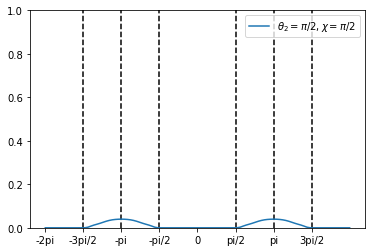

In [8]:
plt.plot(theta_2, p2_K, label='$ \\theta_2 = \pi/2, \\chi = \pi/2$')
plt.ylim(top = 1,bottom = 0)
my_x_ticks = np.arange(-2*np.pi,2*np.pi,np.pi/2) 
plt.xticks(my_x_ticks,('-2pi','-3pi/2','-pi','-pi/2','0','pi/2','pi','3pi/2','2pi'))
plt.vlines(-3*np.pi/2, 0, 1, linestyles = "dashed")
plt.vlines(-np.pi, 0, 1, linestyles = "dashed")
plt.vlines(-np.pi/2, 0, 1, linestyles = "dashed")
plt.vlines(np.pi/2, 0, 1, linestyles = "dashed")
plt.vlines(np.pi, 0, 1, linestyles = "dashed")
plt.vlines(3*np.pi/2, 0, 1, linestyles = "dashed")
plt.legend(loc='best') 

In [6]:
M = 150
n = 1
N = 100
p1_ch_1 = np.zeros(101)
p2_ch_1 = np.zeros(101)
up_state = [0]*M
down_state = [0]*M
aux_state = [0]*M
# up_state[1] = 1/np.sqrt(2)
# down_state[0] = -1j/np.sqrt(2)
down_state[0] = 1
theta_2 = np.linspace(-2*np.pi,2*np.pi,101)
theta_1 = np.pi/3
np.array(up_state)
np.array(down_state)
np.array(aux_state)
init_state = np.vstack((up_state, down_state, aux_state))
for i,theta in enumerate(theta_2):
    state1 = N_step_2_ch_1(init_state, theta, theta_1, N=70)
    state2 = N_step_2_ch_1(init_state, theta, -theta_1, N=70)
    P1 = abs(state1[0])**2 + abs(state1[1])**2 + abs(state1[2])**2
    P2 = abs(state2[0])**2 + abs(state2[1])**2 + abs(state2[2])**2
    p1_ch_1[i] = P1[0] + P1[1] + P1[2] 
    p2_ch_1[i] = P2[0] + P2[1] + P2[2]

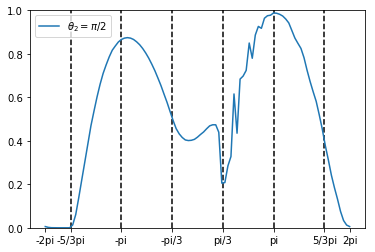

In [184]:
plt.plot(theta_2, p1_ch_1, label='$ \\theta_2 = \pi/2$')
plt.ylim(top = 1,bottom = 0)
my_x_ticks = [-2*np.pi, -5/3*np.pi, -np.pi, -np.pi/3, np.pi/3, np.pi, 5/3*np.pi, 2*np.pi] 
plt.xticks(my_x_ticks,('-2pi','-5/3pi','-pi','-pi/3','pi/3','pi','5/3pi','2pi'))
plt.vlines(-5/3*np.pi, 0, 1, linestyles = "dashed")
plt.vlines(-np.pi, 0, 1, linestyles = "dashed")
plt.vlines(-np.pi/3, 0, 1, linestyles = "dashed")
plt.vlines(np.pi/3, 0, 1, linestyles = "dashed")
plt.vlines(np.pi, 0, 1, linestyles = "dashed")
plt.vlines(5*np.pi/3, 0, 1, linestyles = "dashed")
plt.legend(loc='best') 

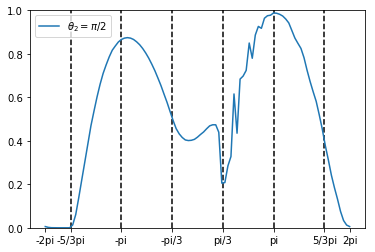

In [185]:
plt.plot(theta_2, p2_ch_1, label='$ \\theta_2 = \pi/2$')
plt.ylim(top = 1,bottom = 0)
my_x_ticks = [-2*np.pi, -5/3*np.pi, -np.pi, -np.pi/3, np.pi/3, np.pi, 5/3*np.pi, 2*np.pi] 
plt.xticks(my_x_ticks,('-2pi','-5/3pi','-pi','-pi/3','pi/3','pi','5/3pi','2pi'))
plt.vlines(-5/3*np.pi, 0, 1, linestyles = "dashed")
plt.vlines(-np.pi, 0, 1, linestyles = "dashed")
plt.vlines(-np.pi/3, 0, 1, linestyles = "dashed")
plt.vlines(np.pi/3, 0, 1, linestyles = "dashed")
plt.vlines(np.pi, 0, 1, linestyles = "dashed")
plt.vlines(5*np.pi/3, 0, 1, linestyles = "dashed")
plt.legend(loc='best') 

In [189]:
M = 150
n = 1
N = 100
p1_ch_2 = np.zeros(101)
p2_ch_2 = np.zeros(101)
up_state = [0]*M
down_state = [0]*M
aux_state = [0]*M
# up_state[1] = 1/np.sqrt(2)
# down_state[0] = -1j/np.sqrt(2)
down_state[0] = 1
theta_2 = np.linspace(-2*np.pi,2*np.pi,101)
theta_1 = np.pi/2
np.array(up_state)
np.array(down_state)
np.array(aux_state)
init_state = np.vstack((up_state, down_state, aux_state))
for i,theta in enumerate(theta_2):
#     state1 = N_step_2_ch_2(init_state, theta, theta_1, N=100)
#     state2 = N_step_2_ch_2(init_state, theta, -theta_1, N=100)
    state1 = N_step_2_ch_2(init_state, theta_1, theta, N=100)
    state2 = N_step_2_ch_2(init_state, -theta_1, theta, N=100)
    P1 = abs(state1[0])**2 + abs(state1[1])**2 + abs(state1[2])**2
    P2 = abs(state2[0])**2 + abs(state2[1])**2 + abs(state2[2])**2
    p1_ch_2[i] = P1[0] + P1[1] + P1[2] 
    p2_ch_2[i] = P2[0] + P2[1] + P2[2]

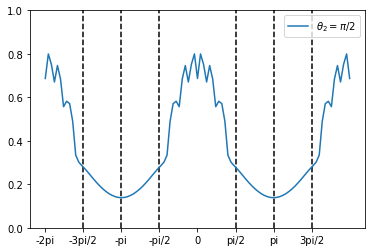

In [190]:
plt.plot(theta_2, p1_ch_2, label='$ \\theta_2 = \pi/2$')
plt.ylim(top = 1,bottom = 0)
my_x_ticks = np.arange(-2*np.pi,2*np.pi,np.pi/2) 
plt.xticks(my_x_ticks,('-2pi','-3pi/2','-pi','-pi/2','0','pi/2','pi','3pi/2','2pi'))
plt.vlines(-3*np.pi/2, 0, 1, linestyles = "dashed")
plt.vlines(-np.pi, 0, 1, linestyles = "dashed")
plt.vlines(-np.pi/2, 0, 1, linestyles = "dashed")
plt.vlines(np.pi/2, 0, 1, linestyles = "dashed")
plt.vlines(np.pi, 0, 1, linestyles = "dashed")
plt.vlines(3*np.pi/2, 0, 1, linestyles = "dashed")
plt.legend(loc='best') 

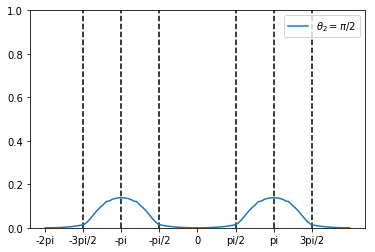

In [191]:
plt.plot(theta_2, p2_ch_2, label='$ \\theta_2 = \pi/2$')
plt.ylim(top = 1,bottom = 0)
my_x_ticks = np.arange(-2*np.pi,2*np.pi,np.pi/2) 
plt.xticks(my_x_ticks,('-2pi','-3pi/2','-pi','-pi/2','0','pi/2','pi','3pi/2','2pi'))
plt.vlines(-3*np.pi/2, 0, 1, linestyles = "dashed")
plt.vlines(-np.pi, 0, 1, linestyles = "dashed")
plt.vlines(-np.pi/2, 0, 1, linestyles = "dashed")
plt.vlines(np.pi/2, 0, 1, linestyles = "dashed")
plt.vlines(np.pi, 0, 1, linestyles = "dashed")
plt.vlines(3*np.pi/2, 0, 1, linestyles = "dashed")
plt.legend(loc='best') 

In [321]:
from ipywidgets import interact, interactive, fixed, interact_manual 
import ipywidgets as widgets 

import matplotlib.pyplot as plt 
%matplotlib inline 

import numpy as np 
M = 100
n = 1

chi = np.pi/3
up_state = [0]*M
down_state = [0]*M
aux_state = [0]*M
down_state[0] = 1
# up_state[1] = 1/np.sqrt(2)
# down_state[0] = -1j/np.sqrt(2)

np.array(up_state)
np.array(down_state)
np.array(aux_state)
init_state = np.vstack((up_state, down_state, aux_state))
plt.figure()

def plot_func(n,theta_1,theta_2):
    n = int(n)
    state = N_step_2_k(init_state, theta_1, theta_2, chi, N=n)
    P = abs(state[0])**2 + abs(state[1])**2 + abs(state[2])**2
    phonon = np.arange(0, len(P)) 
    plt.bar(phonon ,P) 
    plt.xlim(0,50)
    plt.ylim(0,1)

interact(plot_func, n = widgets.FloatSlider(value=0, 
               min=0, 
               max=89, 
               step=1),theta_1 = widgets.FloatSlider(value=np.pi, 
               min=-2*np.pi, 
               max=2*np.pi, 
               step=0.05*np.pi),theta_2 =widgets.FloatSlider(value=np.pi/2, 
               min=-2*np.pi, 
               max=2*np.pi, 
               step=0.01)) 
plt.show()

<Figure size 432x288 with 0 Axes>

interactive(children=(FloatSlider(value=0.0, description='n', max=89.0, step=1.0), FloatSlider(value=3.1415926â€¦

# Plot 3D projection

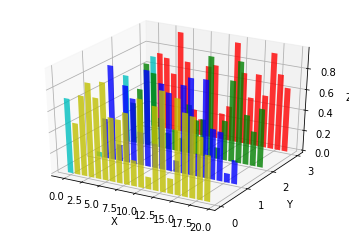

In [87]:
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import matplotlib.pyplot as plt
import numpy as np

# Fixing random state for reproducibility
np.random.seed(19680801)


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

colors = ['r', 'g', 'b', 'y']
yticks = [3, 2, 1, 0]


for c, k in zip(colors, yticks):
    # Generate the random data for the y=k 'layer'.
    xs = np.arange(20)
    ys = np.random.rand(20)

    # You can provide either a single color or an array with the same length as
    # xs and ys. To demonstrate this, we color the first bar of each set cyan.
    cs = [c] * len(xs)
    cs[0] = 'c'

    # Plot the bar graph given by xs and ys on the plane y=k with 80% opacity.
    ax.bar(xs, ys, zs=k, zdir='y', color=cs, alpha=0.8)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# On the y axis let's only label the discrete values that we have data for.
ax.set_yticks(yticks)

plt.show()

# In this example show the phonon distribution

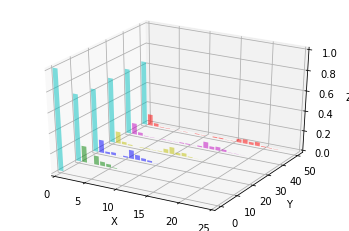

In [104]:
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import matplotlib.pyplot as plt
import numpy as np


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

colors = ['c', 'g', 'b', 'y', 'm', 'r']
yticks = [0, 10, 20, 30, 40, 50]

M = 100
# up_state[0] = 1
# up_state[1] = 1/np.sqrt(2)
# down_state[0] = -1j/np.sqrt(2)

up_state = [0]*M
down_state = [0]*M
aux_state = [0]*M
down_state[0] = 1

np.array(up_state)
np.array(down_state)
np.array(aux_state)
init_state = np.vstack((up_state, down_state, aux_state))

theta_1 = 3*np.pi/4
theta_2 = np.pi/2

for c, k in zip(colors, yticks):
    # Generate the random data for the y=k 'layer'.
    
    state = N_step_2_y(init_state, theta_1, theta_2, N=int(k))
    ys = abs(state[0])**2 + abs(state[1])**2 + abs(state[2])**2
    xs = np.arange(len(ys))
    # You can provide either a single color or an array with the same length as
    # xs and ys. To demonstrate this, we color the first bar of each set cyan.
    cs = [c] * len(xs)
    cs[0] = 'c'

    # Plot the bar graph given by xs and ys on the plane y=k with 80% opacity.
    ax.bar(xs, ys, zs=k, zdir='y', color=cs, alpha=0.5)
    plt.xlim(0,25)
    

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# On the y axis let's only label the discrete values that we have data for.
ax.set_yticks(yticks)

plt.show()

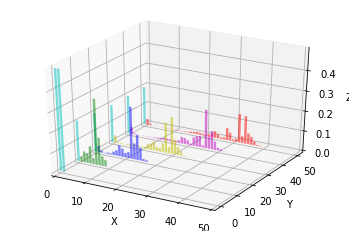

In [219]:
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import matplotlib.pyplot as plt
import numpy as np


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

colors = ['c', 'g', 'b', 'y', 'm', 'r']
yticks = [0, 10, 20, 30, 40, 50]

M = 100

up_state = [0]*M
down_state = [0]*M
aux_state = [0]*M
# down_state[0] = 1
# up_state[0] = 1
up_state[1] = 1/np.sqrt(2)
down_state[0] = -1j/np.sqrt(2)

np.array(up_state)
np.array(down_state)
np.array(aux_state)
init_state = np.vstack((up_state, down_state, aux_state))

theta_1 = 3*np.pi/4
theta_2 = np.pi/2

for c, k in zip(colors, yticks):
    # Generate the random data for the y=k 'layer'.
    
    state = N_step_2_z(init_state, theta_1, theta_2, N=int(k))
    ys = abs(state[0])**2 + abs(state[1])**2 + abs(state[2])**2
    xs = np.arange(len(ys))
    # You can provide either a single color or an array with the same length as
    # xs and ys. To demonstrate this, we color the first bar of each set cyan.
    cs = [c] * len(xs)
    cs[0] = 'c'

    # Plot the bar graph given by xs and ys on the plane y=k with 80% opacity.
    ax.bar(xs, ys, zs=k, zdir='y', color=cs, alpha=0.5)
    plt.xlim(0,50)
    

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# On the y axis let's only label the discrete values that we have data for.
ax.set_yticks(yticks)

plt.show()

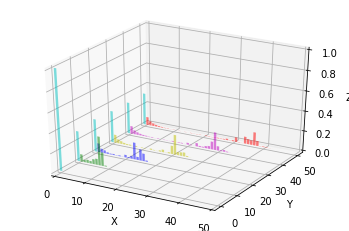

In [121]:
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import matplotlib.pyplot as plt
import numpy as np


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

colors = ['c', 'g', 'b', 'y', 'm', 'r']
yticks = [0, 10, 20, 30, 40, 50]

M = 100

up_state = [0]*M
down_state = [0]*M
aux_state = [0]*M
down_state[0] = 1
# up_state[0] = 1
# up_state[1] = 1/np.sqrt(2)
# down_state[0] = -1j/np.sqrt(2)

np.array(up_state)
np.array(down_state)
np.array(aux_state)
init_state = np.vstack((up_state, down_state, aux_state))

theta_1 = 3*np.pi/4
theta_2 = np.pi/2

for c, k in zip(colors, yticks):
    # Generate the random data for the y=k 'layer'.
    
    state = N_step_2_k(init_state, theta_1, theta_2, N=int(k))
    ys = abs(state[0])**2 + abs(state[1])**2 + abs(state[2])**2
    xs = np.arange(len(ys))
    # You can provide either a single color or an array with the same length as
    # xs and ys. To demonstrate this, we color the first bar of each set cyan.
    cs = [c] * len(xs)
    cs[0] = 'c'

    # Plot the bar graph given by xs and ys on the plane y=k with 80% opacity.
    ax.bar(xs, ys, zs=k, zdir='y', color=cs, alpha=0.5)
    plt.xlim(0,50)
    

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# On the y axis let's only label the discrete values that we have data for.
ax.set_yticks(yticks)

plt.show()

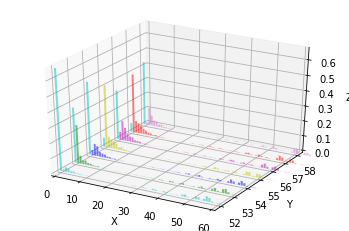

In [202]:
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import matplotlib.pyplot as plt
import numpy as np


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

colors = ['c', 'g', 'b', 'y', 'm', 'r', 'orchid']
yticks = [ 52, 53, 54, 55, 56, 57, 58]

M = 100

up_state = [0]*M
down_state = [0]*M
aux_state = [0]*M
down_state[0] = 1
# up_state[1] = 1/np.sqrt(2)
# down_state[0] = -1j/np.sqrt(2)

np.array(up_state)
np.array(down_state)
np.array(aux_state)
init_state = np.vstack((up_state, down_state, aux_state))

theta_1 = 3*np.pi/4
theta_2 = np.pi/2

for c, k in zip(colors, yticks):
    # Generate the random data for the y=k 'layer'.
    
    state = N_step_2_ch_1(init_state, theta_1, theta_2, N=int(k))
    ys = abs(state[0])**2 + abs(state[1])**2 + abs(state[2])**2
    xs = np.arange(len(ys))
    # You can provide either a single color or an array with the same length as
    # xs and ys. To demonstrate this, we color the first bar of each set cyan.
    cs = [c] * len(xs)
    cs[0] = 'c'

    # Plot the bar graph given by xs and ys on the plane y=k with 80% opacity.
    ax.bar(xs, ys, zs=k, zdir='y', color=cs, alpha=0.5)
    plt.xlim(0,60)
    

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# On the y axis let's only label the discrete values that we have data for.
ax.set_yticks(yticks)

plt.show()